# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

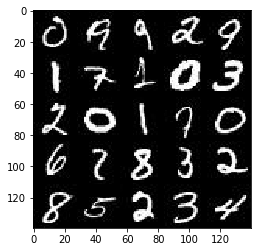

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

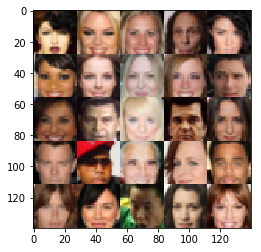

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real'),
            tf.placeholder(tf.float32, (None, z_dim), name='input_z'), 
            tf.placeholder(tf.float32, name='learning_rate'))
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h = tf.maximum(alpha * h, h)
        
        h = tf.layers.conv2d(h, 128, 5, strides=1, padding='same')
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha * h, h)
        
        h = tf.layers.conv2d(h, 256, 5, strides=2, padding='same')
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha * h, h)
        
        logits = tf.layers.dense(tf.reshape(h, (-1, 7*7*256)), 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        h = tf.layers.dense(z, 7*7*256)
        
        h = tf.reshape(h, (-1, 7, 7, 256))
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        
        
        h = tf.layers.conv2d_transpose(h, 128, 5, strides=1, padding='same')
        h = tf.layers.batch_normalization(h, training=is_train)
        lrelu2 = tf.maximum(alpha * h, h)
       
        
        h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, padding='same')
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
       
        logits = tf.layers.conv2d_transpose(h, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
       
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * 0.9))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_count = 0
    
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 1.8437... Generator Loss: 0.3315
Epoch 1/2... Discriminator Loss: 2.4954... Generator Loss: 0.2157
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 1.0981
Epoch 1/2... Discriminator Loss: 1.6281... Generator Loss: 0.5197
Epoch 1/2... Discriminator Loss: 1.6711... Generator Loss: 2.9958
Epoch 1/2... Discriminator Loss: 1.9464... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 1.3021
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.3246
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.6614


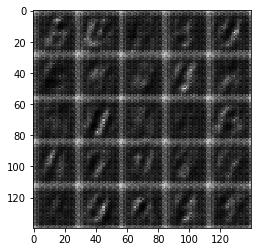

Epoch 1/2... Discriminator Loss: 1.6361... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 2.6999... Generator Loss: 0.1237
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 1.2551
Epoch 1/2... Discriminator Loss: 2.0392... Generator Loss: 0.4964
Epoch 1/2... Discriminator Loss: 1.6761... Generator Loss: 0.4356
Epoch 1/2... Discriminator Loss: 2.3091... Generator Loss: 0.2036
Epoch 1/2... Discriminator Loss: 1.5729... Generator Loss: 1.9173
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.0845
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 1.0141
Epoch 1/2... Discriminator Loss: 0.8641... Generator Loss: 1.2268


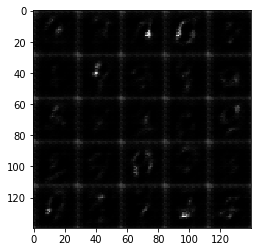

Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 1.8166... Generator Loss: 0.2873
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 1.9221
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 0.9484
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 2.0501
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.9045
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 2.3161


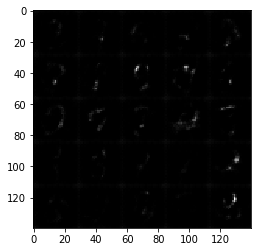

Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.1193
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 1.2441
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.5263
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.9509
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 1.0004
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 1.6145


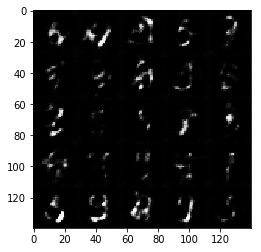

Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.7581
Epoch 1/2... Discriminator Loss: 0.7597... Generator Loss: 1.2985
Epoch 1/2... Discriminator Loss: 1.9242... Generator Loss: 0.3309
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.5006
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.5425... Generator Loss: 0.3868
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.0318


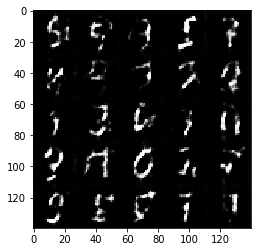

Epoch 1/2... Discriminator Loss: 0.6728... Generator Loss: 1.9085
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 5.3342
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 3.9884
Epoch 1/2... Discriminator Loss: 0.5917... Generator Loss: 2.1341
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 1.5437
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 0.7680... Generator Loss: 1.4159
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 2.7515
Epoch 1/2... Discriminator Loss: 0.7353... Generator Loss: 1.9355


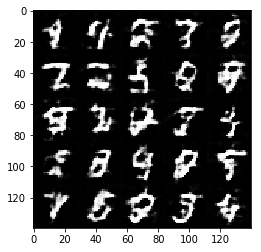

Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 2.2574
Epoch 1/2... Discriminator Loss: 2.3014... Generator Loss: 0.1900
Epoch 1/2... Discriminator Loss: 0.5353... Generator Loss: 2.1986
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 1.6686
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 0.6641... Generator Loss: 1.7424
Epoch 1/2... Discriminator Loss: 0.8178... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.5039
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.6772


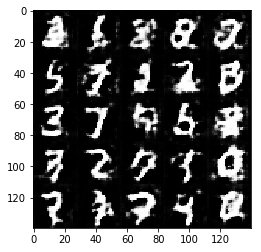

Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 1.5958
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 1.1233
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.6303
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 1.8515... Generator Loss: 0.2693
Epoch 1/2... Discriminator Loss: 0.8209... Generator Loss: 2.5407
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 2.2835
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.1212
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.7547


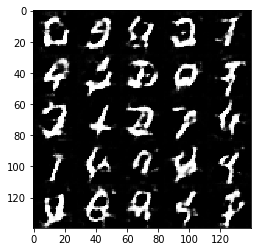

Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.1260
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.7289
Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 1.8175
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 2.3473
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 1.3768
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 1.8858


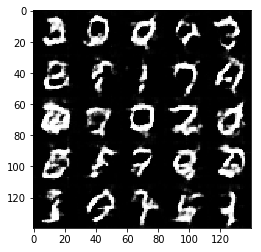

Epoch 1/2... Discriminator Loss: 0.5834... Generator Loss: 2.2433
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 1.7760
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.2064
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.4030
Epoch 1/2... Discriminator Loss: 0.8603... Generator Loss: 1.8773
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 0.8301
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.9870


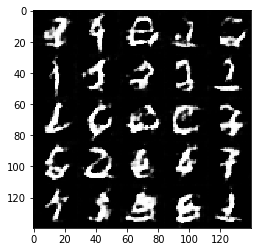

Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 2.9626
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 1.0190
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 1.2014
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.7651
Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 1.7776
Epoch 1/2... Discriminator Loss: 0.8512... Generator Loss: 1.8748
Epoch 1/2... Discriminator Loss: 1.1788... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.4166
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 0.3775


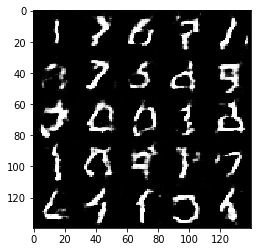

Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 1.5392... Generator Loss: 2.7776
Epoch 1/2... Discriminator Loss: 0.8616... Generator Loss: 2.2780
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 2.0944
Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 1.1614
Epoch 1/2... Discriminator Loss: 0.8771... Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 0.6631... Generator Loss: 1.3971
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 1.2146
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 2.2834


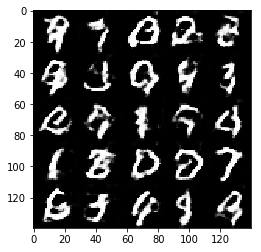

Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 1.3385
Epoch 1/2... Discriminator Loss: 0.9313... Generator Loss: 0.8776
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.6938
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 1.6893
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 0.5470... Generator Loss: 2.0563
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 2.1086
Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 1.2148


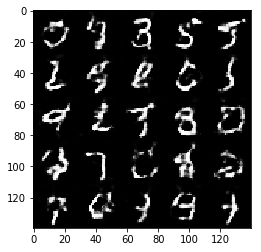

Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.4212
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 1.3344
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 0.6017... Generator Loss: 1.8870
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 1.9307
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 1.0091
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 2.2044
Epoch 1/2... Discriminator Loss: 0.6034... Generator Loss: 1.9630
Epoch 1/2... Discriminator Loss: 2.7226... Generator Loss: 0.1626


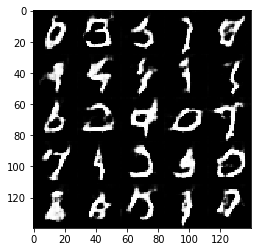

Epoch 1/2... Discriminator Loss: 0.6637... Generator Loss: 1.7062
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 2.6911
Epoch 1/2... Discriminator Loss: 0.5675... Generator Loss: 2.2893
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 3.3688
Epoch 1/2... Discriminator Loss: 2.4707... Generator Loss: 0.2005
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 2.8784
Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 1.4918
Epoch 1/2... Discriminator Loss: 1.5468... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 1.4513


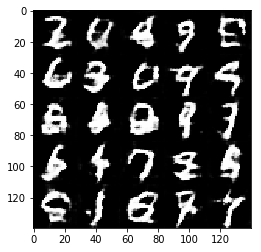

Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 1.0233
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 0.6485... Generator Loss: 2.0520
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.3764
Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 2.1539
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 1.8433
Epoch 1/2... Discriminator Loss: 0.7287... Generator Loss: 2.1315


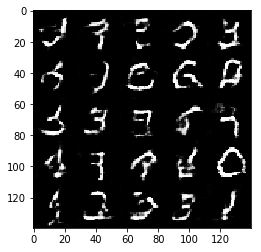

Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 2.0600
Epoch 1/2... Discriminator Loss: 1.8714... Generator Loss: 0.3629
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.5435
Epoch 1/2... Discriminator Loss: 0.8077... Generator Loss: 3.1148
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.6563
Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 1.3944
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.5056


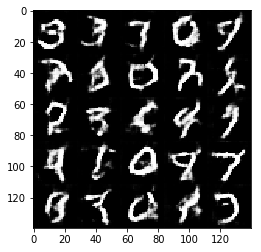

Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 2.1326
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.5476
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 1.0407
Epoch 1/2... Discriminator Loss: 0.5014... Generator Loss: 2.1991
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.2842
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.2335
Epoch 1/2... Discriminator Loss: 0.5185... Generator Loss: 2.2024
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.5986


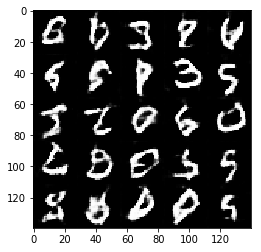

Epoch 1/2... Discriminator Loss: 0.5663... Generator Loss: 2.0275
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.2669
Epoch 1/2... Discriminator Loss: 1.6899... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 1.8572... Generator Loss: 0.3624
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 0.6493... Generator Loss: 1.4579
Epoch 1/2... Discriminator Loss: 0.5701... Generator Loss: 1.6904


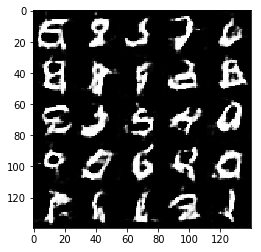

Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 0.6609... Generator Loss: 1.8694
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 1.4806
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 2.7043
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 1.0543
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.9412
Epoch 1/2... Discriminator Loss: 0.8795... Generator Loss: 0.9879
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 1.6716


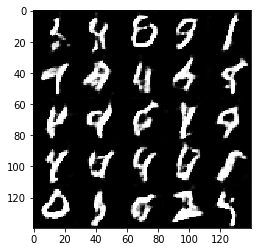

Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 3.1834
Epoch 1/2... Discriminator Loss: 2.2564... Generator Loss: 0.1874
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 1.3122
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 2.0824
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 2.2838
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.2437
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 3.9332
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.1551
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 0.8572


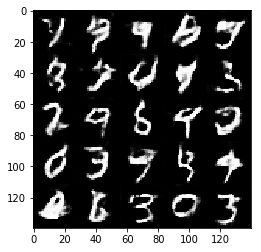

Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 1.6871
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.1422
Epoch 1/2... Discriminator Loss: 0.6398... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 1.7791
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 1.5893
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 0.7488... Generator Loss: 2.5177
Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 1.7782
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 1.9276


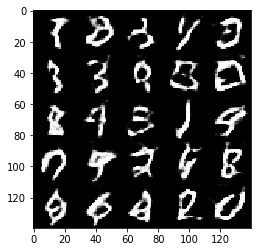

Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 0.9771
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 2.6617... Generator Loss: 0.1761
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 1.6890
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.7326


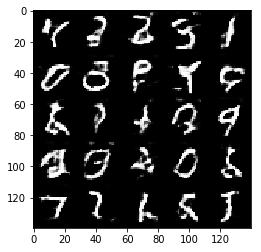

Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 1.4026
Epoch 1/2... Discriminator Loss: 2.5329... Generator Loss: 0.1705
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 1.6112
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 1.1567
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 1.9510
Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 0.5138... Generator Loss: 2.2734
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.6170


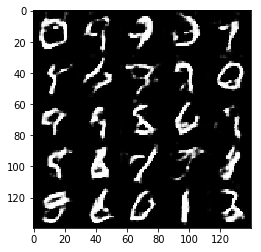

Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.4863
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 1.1429
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 2.3767
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 1.8786... Generator Loss: 0.3444
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 1.2403
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.6763


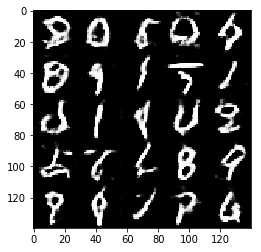

Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 1.2782
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 3.4327
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 1.5962
Epoch 1/2... Discriminator Loss: 0.6804... Generator Loss: 1.4879
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 1.1459
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 1.0010
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 3.5610
Epoch 1/2... Discriminator Loss: 0.6117... Generator Loss: 1.6216


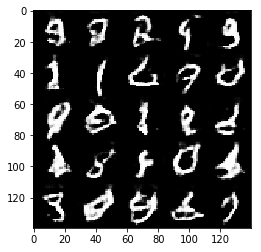

Epoch 1/2... Discriminator Loss: 0.8606... Generator Loss: 1.1262
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 0.5481... Generator Loss: 1.8227
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 2.0043
Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 3.1741
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 1.4548
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 0.4960... Generator Loss: 2.4470
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.6796


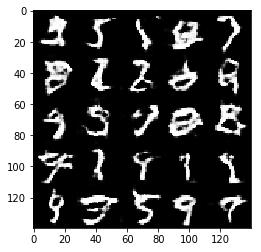

Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 2.7754
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.4122
Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 1.3387
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.4381
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 2.0128... Generator Loss: 0.2973
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 2.3650
Epoch 1/2... Discriminator Loss: 2.0573... Generator Loss: 0.2409
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.6090


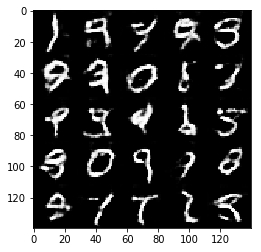

Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.7050
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 1.8045
Epoch 1/2... Discriminator Loss: 0.6214... Generator Loss: 1.6666
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 4.5391
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 3.1503
Epoch 1/2... Discriminator Loss: 0.5098... Generator Loss: 2.7981
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.9076
Epoch 1/2... Discriminator Loss: 0.5665... Generator Loss: 1.8991
Epoch 1/2... Discriminator Loss: 0.5122... Generator Loss: 2.1440


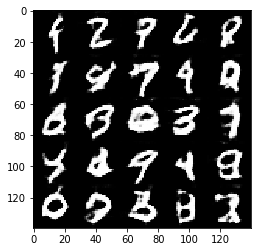

Epoch 1/2... Discriminator Loss: 0.5508... Generator Loss: 1.9123
Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 2.4491
Epoch 1/2... Discriminator Loss: 0.4294... Generator Loss: 3.0764
Epoch 1/2... Discriminator Loss: 1.8424... Generator Loss: 0.4477
Epoch 1/2... Discriminator Loss: 1.6568... Generator Loss: 0.5514
Epoch 1/2... Discriminator Loss: 0.6219... Generator Loss: 1.5817
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.1709
Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.6692


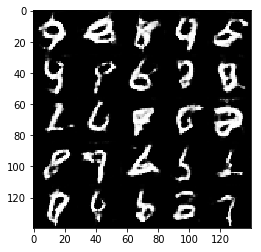

Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.8008
Epoch 1/2... Discriminator Loss: 0.5450... Generator Loss: 1.9218
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 2.0063
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 1.8134... Generator Loss: 0.3427
Epoch 1/2... Discriminator Loss: 0.6143... Generator Loss: 1.7060
Epoch 1/2... Discriminator Loss: 0.4126... Generator Loss: 3.4753
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 2.5503
Epoch 1/2... Discriminator Loss: 0.8229... Generator Loss: 1.1739


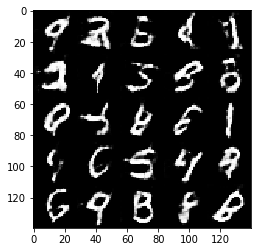

Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 2.3626
Epoch 1/2... Discriminator Loss: 0.4417... Generator Loss: 2.6456
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 2.3325
Epoch 1/2... Discriminator Loss: 0.5623... Generator Loss: 1.9671
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 2.2804
Epoch 1/2... Discriminator Loss: 1.6963... Generator Loss: 3.6687
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.1080
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.6542


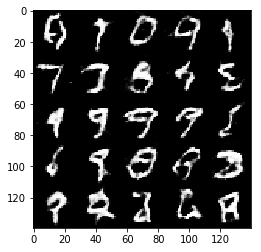

Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 2.7644
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 1.5452
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.6957
Epoch 1/2... Discriminator Loss: 0.7298... Generator Loss: 1.5833
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 1.7036
Epoch 1/2... Discriminator Loss: 0.6017... Generator Loss: 1.8841
Epoch 1/2... Discriminator Loss: 0.6763... Generator Loss: 1.8173
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.2321
Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 1.8381


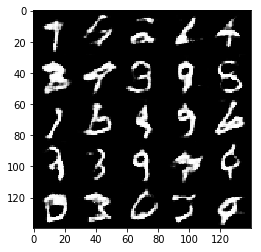

Epoch 1/2... Discriminator Loss: 0.6903... Generator Loss: 3.3389
Epoch 1/2... Discriminator Loss: 2.8370... Generator Loss: 0.1175
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.9266
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.2110
Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 1.9578
Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 1.7333
Epoch 1/2... Discriminator Loss: 0.5746... Generator Loss: 2.0534
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.1831
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 1.1472


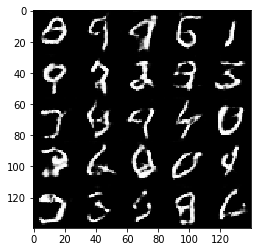

Epoch 1/2... Discriminator Loss: 0.5845... Generator Loss: 1.8541
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 1.9647
Epoch 1/2... Discriminator Loss: 2.0891... Generator Loss: 0.2763
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.8717
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 2.5804
Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 2.6493
Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 3.9506


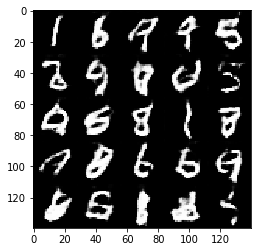

Epoch 1/2... Discriminator Loss: 0.6269... Generator Loss: 2.5585
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.8641
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 1.7895
Epoch 1/2... Discriminator Loss: 0.5754... Generator Loss: 1.9267
Epoch 1/2... Discriminator Loss: 0.6759... Generator Loss: 1.6682
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.2595
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 1.8763
Epoch 1/2... Discriminator Loss: 0.7150... Generator Loss: 1.3062
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 1.8661
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 3.0693


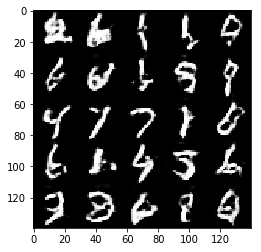

Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 2.3971
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 3.5031
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 1.0756
Epoch 1/2... Discriminator Loss: 0.4698... Generator Loss: 2.7029
Epoch 1/2... Discriminator Loss: 1.6273... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.9716... Generator Loss: 0.2615
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 0.9479
Epoch 1/2... Discriminator Loss: 0.5087... Generator Loss: 2.1031
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 2.3488
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 2.7348


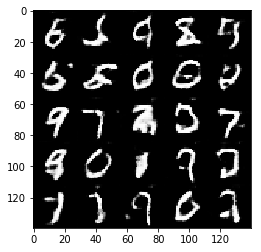

Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.5563
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 1.7498
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.4073
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.0560
Epoch 1/2... Discriminator Loss: 1.7952... Generator Loss: 0.3623
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 1.3378
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 1.0670


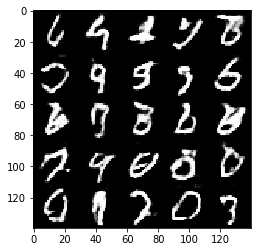

Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 1.2711
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 1.9689
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 0.6445... Generator Loss: 1.5483
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.2110
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.2662
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 1.7861... Generator Loss: 4.3256
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.2738


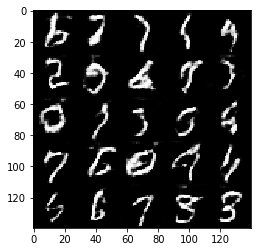

Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.1462
Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 1.2912
Epoch 1/2... Discriminator Loss: 0.4632... Generator Loss: 2.3401
Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 2.3282
Epoch 1/2... Discriminator Loss: 0.4336... Generator Loss: 2.9923
Epoch 1/2... Discriminator Loss: 0.7262... Generator Loss: 1.2905
Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 1.8684... Generator Loss: 0.3201


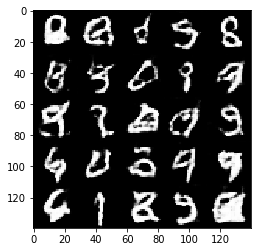

Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.2630
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 0.4655... Generator Loss: 2.4805
Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 2.7019
Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 1.6357
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.7121
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 2.0861... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.5990


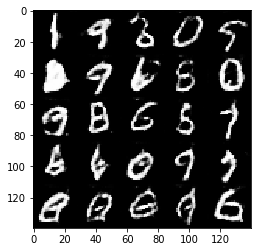

Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 1.5045
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.4897
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 0.5109... Generator Loss: 2.3925
Epoch 1/2... Discriminator Loss: 0.5859... Generator Loss: 1.7863
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 2.9460
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 1.1186
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 1.9377
Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 2.1147


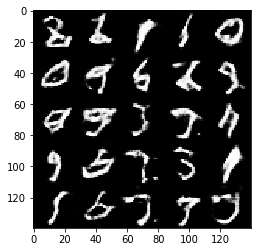

Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 2.0492
Epoch 1/2... Discriminator Loss: 0.4114... Generator Loss: 3.3173
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 1.8431
Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 1.3584
Epoch 1/2... Discriminator Loss: 0.4891... Generator Loss: 2.3295
Epoch 1/2... Discriminator Loss: 0.5683... Generator Loss: 2.2868
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 1.8079
Epoch 1/2... Discriminator Loss: 0.6538... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.5179
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 1.0994


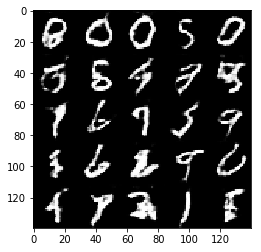

Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.8396
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.8528
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 1.5645
Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 1.8718
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.7831
Epoch 1/2... Discriminator Loss: 0.5524... Generator Loss: 1.9201
Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.4528
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.8462
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 1.0954


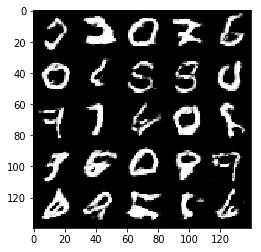

Epoch 1/2... Discriminator Loss: 0.5990... Generator Loss: 1.9246
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 0.8696
Epoch 1/2... Discriminator Loss: 0.5511... Generator Loss: 1.8715
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 3.3807
Epoch 1/2... Discriminator Loss: 0.5153... Generator Loss: 3.8193
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 2.6804
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 0.5023... Generator Loss: 2.5879
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 2.0246... Generator Loss: 0.2673


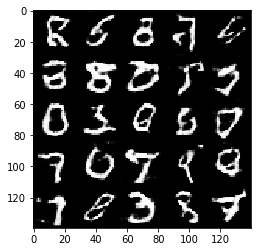

Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 0.5879... Generator Loss: 1.8864
Epoch 1/2... Discriminator Loss: 0.5006... Generator Loss: 2.6262
Epoch 1/2... Discriminator Loss: 0.4158... Generator Loss: 3.6680
Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.4647
Epoch 1/2... Discriminator Loss: 0.5355... Generator Loss: 1.9509
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 1.6775
Epoch 1/2... Discriminator Loss: 3.2113... Generator Loss: 0.2166
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 2.0359
Epoch 1/2... Discriminator Loss: 1.6916... Generator Loss: 0.3867


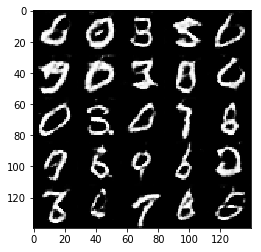

Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 1.6078
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.4459... Generator Loss: 2.9038
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.2457
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 0.4960... Generator Loss: 3.4926
Epoch 1/2... Discriminator Loss: 0.6939... Generator Loss: 1.4140
Epoch 1/2... Discriminator Loss: 0.4875... Generator Loss: 2.6203
Epoch 1/2... Discriminator Loss: 0.4898... Generator Loss: 2.3389
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.3894


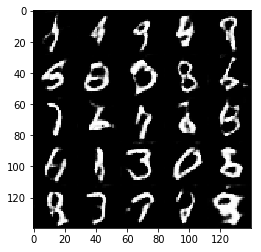

Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 1.7811
Epoch 1/2... Discriminator Loss: 0.5304... Generator Loss: 1.8794
Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 0.5420
Epoch 1/2... Discriminator Loss: 0.6036... Generator Loss: 2.4428
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.3667
Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 2.1545
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 1.7917
Epoch 1/2... Discriminator Loss: 0.4501... Generator Loss: 3.1465
Epoch 1/2... Discriminator Loss: 0.5998... Generator Loss: 2.3982
Epoch 1/2... Discriminator Loss: 0.5780... Generator Loss: 1.8579


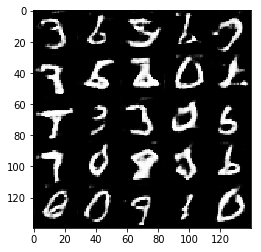

Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 0.5871... Generator Loss: 1.9592
Epoch 1/2... Discriminator Loss: 0.4868... Generator Loss: 2.8098
Epoch 1/2... Discriminator Loss: 1.9860... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 1.9703
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 2.5030
Epoch 1/2... Discriminator Loss: 0.5441... Generator Loss: 2.4248
Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 3.7112
Epoch 1/2... Discriminator Loss: 0.7341... Generator Loss: 1.3732


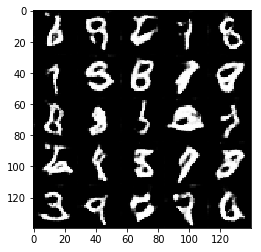

Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.2938
Epoch 1/2... Discriminator Loss: 2.1502... Generator Loss: 0.4715
Epoch 1/2... Discriminator Loss: 0.5068... Generator Loss: 2.1094
Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 1.9882
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.5403
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 1.7466
Epoch 1/2... Discriminator Loss: 0.5998... Generator Loss: 2.8156
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 2.4765


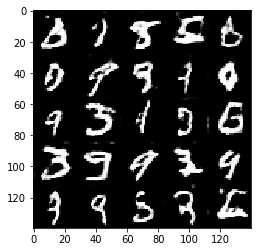

Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 2.7864
Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 2.0273
Epoch 1/2... Discriminator Loss: 0.5919... Generator Loss: 1.7213
Epoch 1/2... Discriminator Loss: 0.4617... Generator Loss: 2.4880
Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 2.0284
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 1.0937
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 5.3280
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 2.0954
Epoch 1/2... Discriminator Loss: 0.4553... Generator Loss: 2.5233


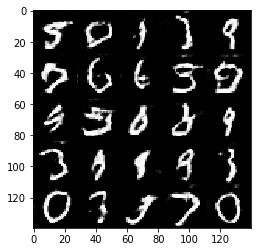

Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 1.1221
Epoch 1/2... Discriminator Loss: 0.6583... Generator Loss: 1.6038
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 2.5097
Epoch 1/2... Discriminator Loss: 0.4792... Generator Loss: 2.4755
Epoch 1/2... Discriminator Loss: 1.5627... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.7530
Epoch 1/2... Discriminator Loss: 0.8853... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.7305
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.2887
Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 3.1931


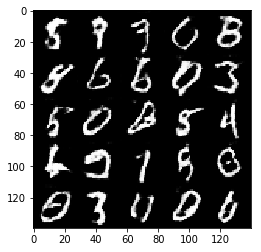

Epoch 1/2... Discriminator Loss: 0.7885... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 1.9872
Epoch 1/2... Discriminator Loss: 0.7300... Generator Loss: 2.7599
Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 1.3249
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 1.8493
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 1.4655
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.2072
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.6182
Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 2.5908
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 1.7016


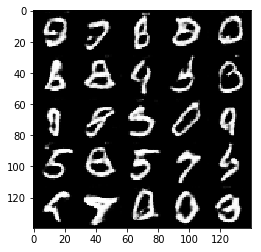

Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 0.7336
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.6072
Epoch 1/2... Discriminator Loss: 0.5461... Generator Loss: 2.0959
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 0.9684
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.4999... Generator Loss: 2.2838
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 2.1953
Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 1.7202


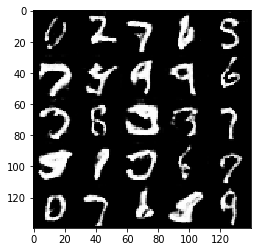

Epoch 1/2... Discriminator Loss: 0.5046... Generator Loss: 2.5242
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 0.6176... Generator Loss: 2.2226
Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 1.4675
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 3.0710
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 2.5915
Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.3095
Epoch 1/2... Discriminator Loss: 0.6347... Generator Loss: 2.0289


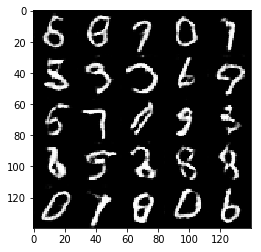

Epoch 1/2... Discriminator Loss: 0.4137... Generator Loss: 3.0225
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.1187
Epoch 1/2... Discriminator Loss: 0.5165... Generator Loss: 1.9925
Epoch 1/2... Discriminator Loss: 0.4372... Generator Loss: 2.6716
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 2.4590
Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 1.3797
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 2.3900
Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 2.8925


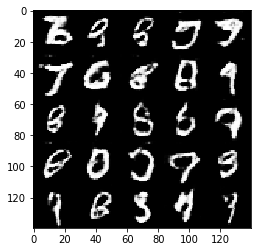

Epoch 1/2... Discriminator Loss: 0.4934... Generator Loss: 2.5115
Epoch 1/2... Discriminator Loss: 0.7077... Generator Loss: 1.5101
Epoch 1/2... Discriminator Loss: 0.5023... Generator Loss: 2.1045
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.3038
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 0.4982... Generator Loss: 3.8556
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 1.1027
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 1.9139
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.6750
Epoch 1/2... Discriminator Loss: 0.4235... Generator Loss: 3.7876


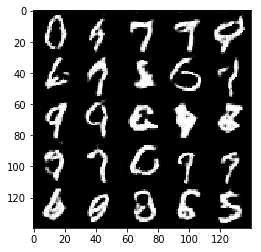

Epoch 1/2... Discriminator Loss: 0.4520... Generator Loss: 2.4709
Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 1.8695
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 1.7701
Epoch 1/2... Discriminator Loss: 0.9766... Generator Loss: 1.1048
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 1.8550
Epoch 1/2... Discriminator Loss: 0.5483... Generator Loss: 1.9037
Epoch 1/2... Discriminator Loss: 0.4058... Generator Loss: 3.1916
Epoch 1/2... Discriminator Loss: 0.5718... Generator Loss: 2.0810
Epoch 1/2... Discriminator Loss: 0.5696... Generator Loss: 2.1658
Epoch 1/2... Discriminator Loss: 0.4430... Generator Loss: 2.5272


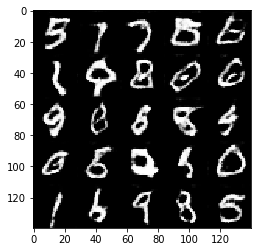

Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 1.6855
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.0953
Epoch 1/2... Discriminator Loss: 0.5331... Generator Loss: 1.9945
Epoch 1/2... Discriminator Loss: 1.5514... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 0.3748... Generator Loss: 4.0675
Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 2.9495
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 3.0951
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 2.3491
Epoch 1/2... Discriminator Loss: 0.3647... Generator Loss: 4.2057
Epoch 1/2... Discriminator Loss: 1.1930... Generator Loss: 0.9516


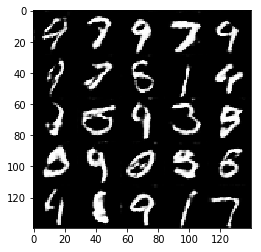

Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 2.3570
Epoch 1/2... Discriminator Loss: 0.4904... Generator Loss: 2.5442
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.7550
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 3.2980
Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 1.2551
Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 2.3969
Epoch 1/2... Discriminator Loss: 0.6879... Generator Loss: 1.3817
Epoch 1/2... Discriminator Loss: 0.6887... Generator Loss: 1.6252
Epoch 1/2... Discriminator Loss: 0.4772... Generator Loss: 2.6110
Epoch 1/2... Discriminator Loss: 0.4925... Generator Loss: 2.1734


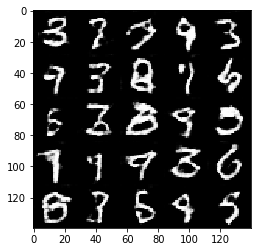

Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.4991
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.4359
Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.7643
Epoch 2/2... Discriminator Loss: 0.4845... Generator Loss: 2.2361
Epoch 2/2... Discriminator Loss: 0.4610... Generator Loss: 2.4513
Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 2.4862
Epoch 2/2... Discriminator Loss: 0.4764... Generator Loss: 2.5269
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 3.4056
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 2.7092
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.2911


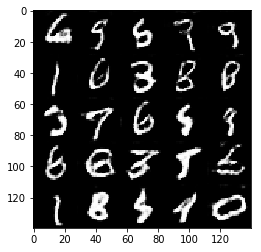

Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 1.9264
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.7689
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 2.6869
Epoch 2/2... Discriminator Loss: 0.4439... Generator Loss: 2.8058
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 3.0639
Epoch 2/2... Discriminator Loss: 0.4564... Generator Loss: 3.5376
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 2.3375
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 2.2633
Epoch 2/2... Discriminator Loss: 0.4948... Generator Loss: 2.2166
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 1.9335


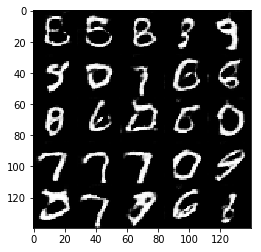

Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.3082
Epoch 2/2... Discriminator Loss: 0.3830... Generator Loss: 3.5435
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 1.9316
Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 3.0772
Epoch 2/2... Discriminator Loss: 0.4685... Generator Loss: 3.3487
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.6374
Epoch 2/2... Discriminator Loss: 0.5772... Generator Loss: 1.8547
Epoch 2/2... Discriminator Loss: 0.4486... Generator Loss: 2.8140
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.8861
Epoch 2/2... Discriminator Loss: 0.4353... Generator Loss: 2.7157


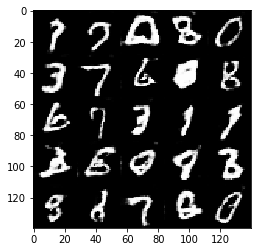

Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 1.9524
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.3207
Epoch 2/2... Discriminator Loss: 0.5871... Generator Loss: 2.4605
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 1.7817
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.6325
Epoch 2/2... Discriminator Loss: 0.6945... Generator Loss: 1.7098
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 1.8125
Epoch 2/2... Discriminator Loss: 0.4780... Generator Loss: 2.3917


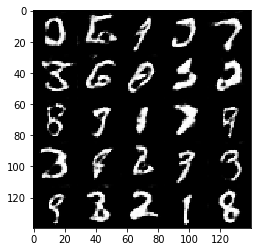

Epoch 2/2... Discriminator Loss: 0.4195... Generator Loss: 3.1140
Epoch 2/2... Discriminator Loss: 1.9590... Generator Loss: 0.4465
Epoch 2/2... Discriminator Loss: 0.4796... Generator Loss: 2.5885
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.7153
Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 2.8577
Epoch 2/2... Discriminator Loss: 0.4888... Generator Loss: 2.5193
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 1.4789
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.3162


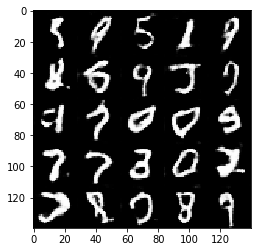

Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 1.9985
Epoch 2/2... Discriminator Loss: 0.7604... Generator Loss: 1.2348
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.6497
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.4228
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.3205
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 0.7989
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 4.1126
Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 3.5943
Epoch 2/2... Discriminator Loss: 0.5281... Generator Loss: 2.6225
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 2.6682


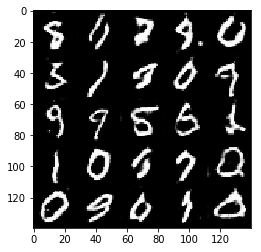

Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.7539
Epoch 2/2... Discriminator Loss: 0.5543... Generator Loss: 1.8019
Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 1.5561
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 2.2121
Epoch 2/2... Discriminator Loss: 0.5352... Generator Loss: 2.1469
Epoch 2/2... Discriminator Loss: 0.5231... Generator Loss: 2.0629
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.4157
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 4.4049
Epoch 2/2... Discriminator Loss: 0.5346... Generator Loss: 3.9243
Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 0.8154


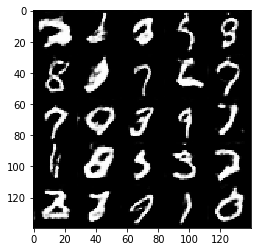

Epoch 2/2... Discriminator Loss: 0.6986... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 2.3844
Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 0.4164... Generator Loss: 3.8650
Epoch 2/2... Discriminator Loss: 0.3979... Generator Loss: 3.1582
Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 2.4421
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 1.6208
Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 1.8651
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 1.3759


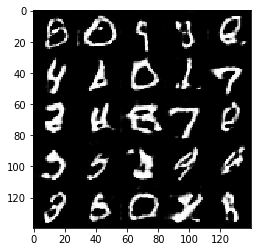

Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.5439
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.3721
Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 3.0386
Epoch 2/2... Discriminator Loss: 0.4189... Generator Loss: 2.8341
Epoch 2/2... Discriminator Loss: 0.4159... Generator Loss: 3.4628
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 2.2301
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 3.3041
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 2.6489


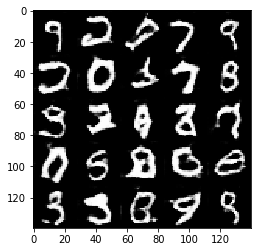

Epoch 2/2... Discriminator Loss: 0.5989... Generator Loss: 1.7255
Epoch 2/2... Discriminator Loss: 0.5603... Generator Loss: 1.8682
Epoch 2/2... Discriminator Loss: 0.4944... Generator Loss: 2.1869
Epoch 2/2... Discriminator Loss: 0.5144... Generator Loss: 2.1683
Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 3.8126
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 3.1790
Epoch 2/2... Discriminator Loss: 0.3842... Generator Loss: 3.6190
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.8078
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 0.3717... Generator Loss: 3.5711


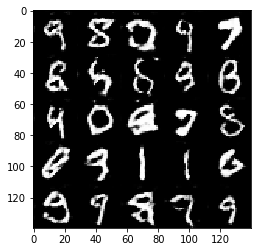

Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 1.8226
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.7884
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.4950
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.4366
Epoch 2/2... Discriminator Loss: 0.5049... Generator Loss: 2.1000
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 2.0040
Epoch 2/2... Discriminator Loss: 0.5417... Generator Loss: 2.2990
Epoch 2/2... Discriminator Loss: 0.5161... Generator Loss: 1.9796
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 1.0017


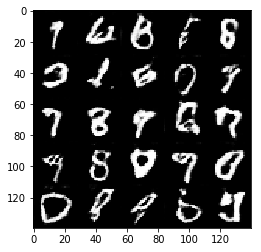

Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 2.0101
Epoch 2/2... Discriminator Loss: 0.4479... Generator Loss: 2.6228
Epoch 2/2... Discriminator Loss: 0.7048... Generator Loss: 1.4176
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.8565
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.6635
Epoch 2/2... Discriminator Loss: 0.5603... Generator Loss: 2.5723
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.3213
Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 3.1513
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 1.6377
Epoch 2/2... Discriminator Loss: 0.3591... Generator Loss: 4.1263


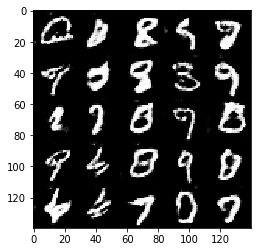

Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 3.3165
Epoch 2/2... Discriminator Loss: 0.4743... Generator Loss: 3.0620
Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.3936
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.4410
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 2.4384
Epoch 2/2... Discriminator Loss: 0.4928... Generator Loss: 2.2463
Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 4.5774
Epoch 2/2... Discriminator Loss: 0.5071... Generator Loss: 2.7027
Epoch 2/2... Discriminator Loss: 0.3987... Generator Loss: 3.3485
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.4700


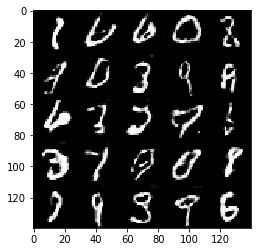

Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 4.1511
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 2.0881
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 0.4624... Generator Loss: 2.3218
Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 2.7009
Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 2.6296
Epoch 2/2... Discriminator Loss: 0.5885... Generator Loss: 1.7411
Epoch 2/2... Discriminator Loss: 0.4065... Generator Loss: 3.2969
Epoch 2/2... Discriminator Loss: 0.4936... Generator Loss: 2.3170
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.7922


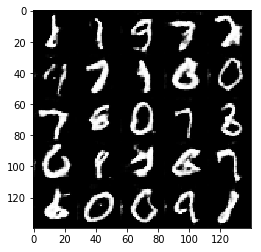

Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 2.8809
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.8982
Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 2.9409
Epoch 2/2... Discriminator Loss: 0.6771... Generator Loss: 1.6725
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 1.3153
Epoch 2/2... Discriminator Loss: 0.3912... Generator Loss: 3.7355
Epoch 2/2... Discriminator Loss: 1.7016... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.1952
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 2.2842
Epoch 2/2... Discriminator Loss: 0.4848... Generator Loss: 2.4152


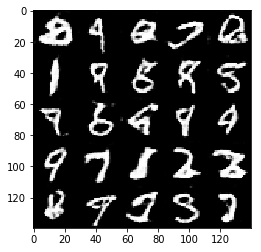

Epoch 2/2... Discriminator Loss: 0.5397... Generator Loss: 3.4716
Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 2.4004
Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.5540
Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 1.7105
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 3.2846
Epoch 2/2... Discriminator Loss: 0.4965... Generator Loss: 2.0452
Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 3.0990
Epoch 2/2... Discriminator Loss: 0.4171... Generator Loss: 2.8695
Epoch 2/2... Discriminator Loss: 0.3949... Generator Loss: 3.7528
Epoch 2/2... Discriminator Loss: 0.5162... Generator Loss: 3.0597


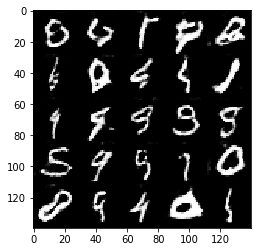

Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 2.8426
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 0.4464... Generator Loss: 2.9324
Epoch 2/2... Discriminator Loss: 0.4921... Generator Loss: 2.3237
Epoch 2/2... Discriminator Loss: 0.5830... Generator Loss: 1.8814
Epoch 2/2... Discriminator Loss: 0.5883... Generator Loss: 1.5809
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 1.8049
Epoch 2/2... Discriminator Loss: 0.4331... Generator Loss: 2.8644
Epoch 2/2... Discriminator Loss: 0.4751... Generator Loss: 2.2938
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.0638


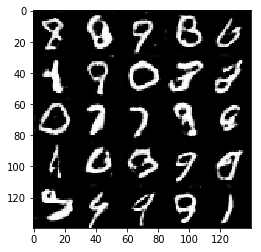

Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 2.3407
Epoch 2/2... Discriminator Loss: 0.3962... Generator Loss: 2.9277
Epoch 2/2... Discriminator Loss: 0.4808... Generator Loss: 2.5549
Epoch 2/2... Discriminator Loss: 0.4016... Generator Loss: 3.3584
Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.7707
Epoch 2/2... Discriminator Loss: 0.3643... Generator Loss: 4.2967
Epoch 2/2... Discriminator Loss: 1.5884... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 2.3762


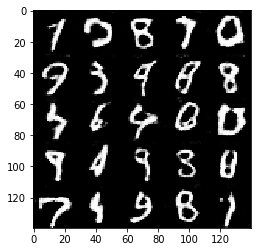

Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 2.2249
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.7528
Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 2.3964
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.7290
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.2627
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.1501
Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 2.4173
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 2.9548
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.8564


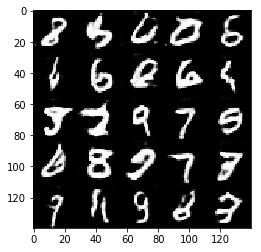

Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.4212
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 3.0967
Epoch 2/2... Discriminator Loss: 0.7293... Generator Loss: 2.3005
Epoch 2/2... Discriminator Loss: 0.4930... Generator Loss: 2.7468
Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 2.4418
Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 2.8018
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.3156
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 4.1005
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 2.3018
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 4.4581


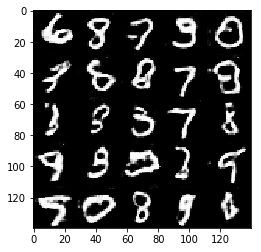

Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 2.9436
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.5331
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 1.8189
Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 2.0770
Epoch 2/2... Discriminator Loss: 0.4451... Generator Loss: 2.5620
Epoch 2/2... Discriminator Loss: 0.4507... Generator Loss: 2.5379
Epoch 2/2... Discriminator Loss: 0.4136... Generator Loss: 3.2818
Epoch 2/2... Discriminator Loss: 0.4175... Generator Loss: 2.9759
Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 2.2021


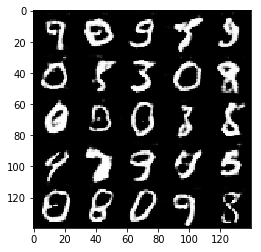

Epoch 2/2... Discriminator Loss: 0.4276... Generator Loss: 2.8910
Epoch 2/2... Discriminator Loss: 0.6071... Generator Loss: 1.8089
Epoch 2/2... Discriminator Loss: 0.5265... Generator Loss: 2.1352
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.6341
Epoch 2/2... Discriminator Loss: 0.4515... Generator Loss: 2.7120
Epoch 2/2... Discriminator Loss: 0.4468... Generator Loss: 2.8894
Epoch 2/2... Discriminator Loss: 0.4333... Generator Loss: 2.6805
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 3.4615
Epoch 2/2... Discriminator Loss: 0.4512... Generator Loss: 2.8193
Epoch 2/2... Discriminator Loss: 0.4013... Generator Loss: 3.2666


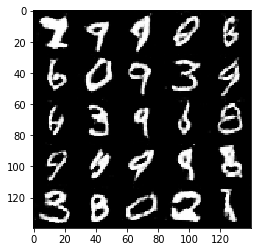

Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 3.2361
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.5418
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.8540
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 2.0921
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 2.1855
Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 2.3459
Epoch 2/2... Discriminator Loss: 0.5662... Generator Loss: 1.8518
Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 2.0725
Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 2.1165
Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.2854


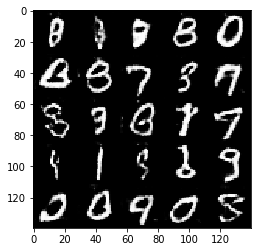

Epoch 2/2... Discriminator Loss: 0.3987... Generator Loss: 3.8192
Epoch 2/2... Discriminator Loss: 0.5196... Generator Loss: 1.9669
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.5560
Epoch 2/2... Discriminator Loss: 0.4168... Generator Loss: 3.0891
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 3.4725
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.7779
Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 3.3392
Epoch 2/2... Discriminator Loss: 0.5754... Generator Loss: 1.8229
Epoch 2/2... Discriminator Loss: 0.4127... Generator Loss: 2.9846
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.7659


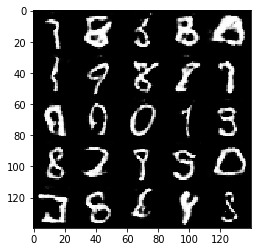

Epoch 2/2... Discriminator Loss: 0.4623... Generator Loss: 2.5736
Epoch 2/2... Discriminator Loss: 0.3776... Generator Loss: 3.4215
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 2.8030
Epoch 2/2... Discriminator Loss: 0.5321... Generator Loss: 2.1292
Epoch 2/2... Discriminator Loss: 0.5669... Generator Loss: 2.0674
Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 3.2162
Epoch 2/2... Discriminator Loss: 0.5662... Generator Loss: 2.4119
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 2.8019
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 3.3436


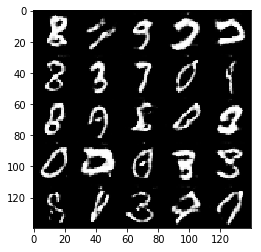

Epoch 2/2... Discriminator Loss: 0.4768... Generator Loss: 2.4859
Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 2.3414
Epoch 2/2... Discriminator Loss: 0.4008... Generator Loss: 3.2687
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 2.3726
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 2.2007
Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 2.4622
Epoch 2/2... Discriminator Loss: 0.4939... Generator Loss: 2.3115
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 1.9914
Epoch 2/2... Discriminator Loss: 0.4874... Generator Loss: 3.5637
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.8706


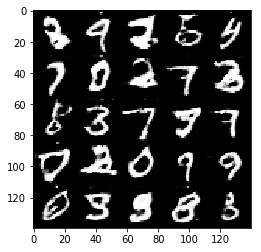

Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 1.7607
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 5.9551
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.6644
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 2.1904
Epoch 2/2... Discriminator Loss: 0.4435... Generator Loss: 2.9717
Epoch 2/2... Discriminator Loss: 0.5377... Generator Loss: 2.5663
Epoch 2/2... Discriminator Loss: 0.6912... Generator Loss: 1.6462
Epoch 2/2... Discriminator Loss: 0.4384... Generator Loss: 2.7827
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.1770


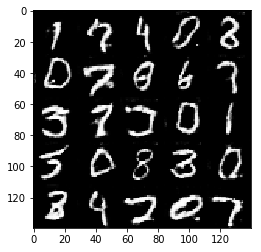

Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.4617
Epoch 2/2... Discriminator Loss: 0.4569... Generator Loss: 2.5029
Epoch 2/2... Discriminator Loss: 0.5853... Generator Loss: 2.4436
Epoch 2/2... Discriminator Loss: 1.5673... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 0.4187... Generator Loss: 3.4197
Epoch 2/2... Discriminator Loss: 0.5228... Generator Loss: 2.2150
Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 1.6107
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 2.0222
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.5332
Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 3.7211


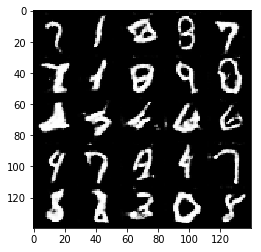

Epoch 2/2... Discriminator Loss: 0.3660... Generator Loss: 4.1384
Epoch 2/2... Discriminator Loss: 0.5904... Generator Loss: 2.0520
Epoch 2/2... Discriminator Loss: 0.3693... Generator Loss: 4.0338
Epoch 2/2... Discriminator Loss: 0.4552... Generator Loss: 2.7413
Epoch 2/2... Discriminator Loss: 0.4853... Generator Loss: 2.4653
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 1.9906
Epoch 2/2... Discriminator Loss: 0.5073... Generator Loss: 3.1905
Epoch 2/2... Discriminator Loss: 0.4299... Generator Loss: 3.5959
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 1.7789
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 2.5549


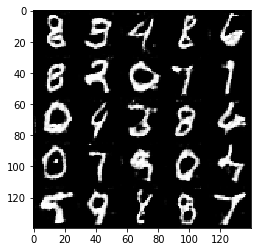

Epoch 2/2... Discriminator Loss: 0.6938... Generator Loss: 1.7847
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 1.4700
Epoch 2/2... Discriminator Loss: 0.4498... Generator Loss: 3.2630
Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 4.0052
Epoch 2/2... Discriminator Loss: 0.5647... Generator Loss: 1.7063
Epoch 2/2... Discriminator Loss: 0.5010... Generator Loss: 2.6489
Epoch 2/2... Discriminator Loss: 0.6005... Generator Loss: 3.2223
Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 3.8254
Epoch 2/2... Discriminator Loss: 0.5458... Generator Loss: 2.3218
Epoch 2/2... Discriminator Loss: 0.4466... Generator Loss: 2.5808


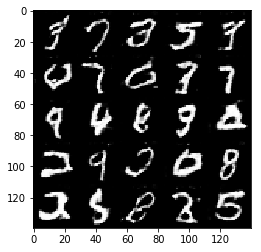

Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 1.4819
Epoch 2/2... Discriminator Loss: 0.5308... Generator Loss: 1.9638
Epoch 2/2... Discriminator Loss: 0.6855... Generator Loss: 1.7197
Epoch 2/2... Discriminator Loss: 0.4429... Generator Loss: 2.6644
Epoch 2/2... Discriminator Loss: 0.4664... Generator Loss: 2.5790
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 2.0246
Epoch 2/2... Discriminator Loss: 0.4788... Generator Loss: 2.2897
Epoch 2/2... Discriminator Loss: 0.4608... Generator Loss: 4.7862
Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 3.9536
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 3.2100


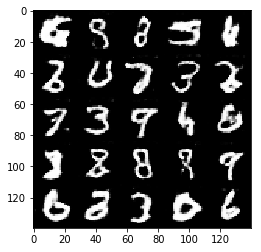

Epoch 2/2... Discriminator Loss: 0.4707... Generator Loss: 2.1255
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 4.2067
Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 0.5111... Generator Loss: 2.1226
Epoch 2/2... Discriminator Loss: 0.4929... Generator Loss: 2.8990
Epoch 2/2... Discriminator Loss: 0.4901... Generator Loss: 2.5792
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.4627... Generator Loss: 2.6273
Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 3.6983
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.2897


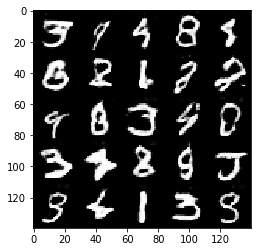

Epoch 2/2... Discriminator Loss: 0.4704... Generator Loss: 2.5172
Epoch 2/2... Discriminator Loss: 0.4879... Generator Loss: 2.5282
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 2.3181
Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 1.7577
Epoch 2/2... Discriminator Loss: 0.4300... Generator Loss: 3.0024
Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 1.6491
Epoch 2/2... Discriminator Loss: 0.3740... Generator Loss: 3.7779
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 1.2056
Epoch 2/2... Discriminator Loss: 0.4522... Generator Loss: 2.4142
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 2.2297


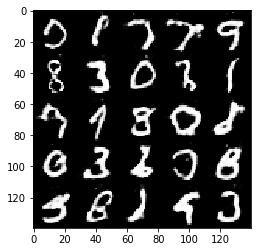

Epoch 2/2... Discriminator Loss: 0.4498... Generator Loss: 2.5146
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 1.5594
Epoch 2/2... Discriminator Loss: 0.4475... Generator Loss: 3.0053
Epoch 2/2... Discriminator Loss: 0.5709... Generator Loss: 1.9353
Epoch 2/2... Discriminator Loss: 0.4237... Generator Loss: 2.5880
Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 3.2354
Epoch 2/2... Discriminator Loss: 0.5681... Generator Loss: 2.0258
Epoch 2/2... Discriminator Loss: 0.4313... Generator Loss: 2.6852
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.8706
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.8736


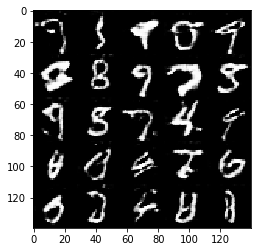

Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 2.5663
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 2.2510
Epoch 2/2... Discriminator Loss: 0.5496... Generator Loss: 2.3322
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.9672
Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 2.0347
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 1.6603
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 1.6279
Epoch 2/2... Discriminator Loss: 0.4819... Generator Loss: 2.2534
Epoch 2/2... Discriminator Loss: 0.5228... Generator Loss: 2.8022
Epoch 2/2... Discriminator Loss: 0.4189... Generator Loss: 3.0217


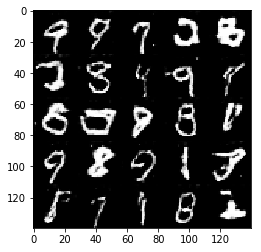

Epoch 2/2... Discriminator Loss: 0.4077... Generator Loss: 2.9983
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 2.7595
Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 3.9502
Epoch 2/2... Discriminator Loss: 0.3694... Generator Loss: 4.0046
Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 2.9007
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 0.3924... Generator Loss: 3.3981
Epoch 2/2... Discriminator Loss: 0.6422... Generator Loss: 1.5572
Epoch 2/2... Discriminator Loss: 0.3941... Generator Loss: 3.7845
Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 2.8089


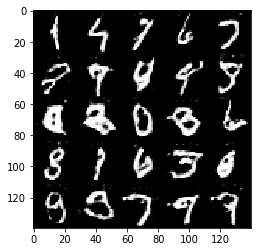

Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 3.8922
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.9696
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.8246
Epoch 2/2... Discriminator Loss: 0.4508... Generator Loss: 2.9035
Epoch 2/2... Discriminator Loss: 0.4465... Generator Loss: 3.2101
Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 0.4942... Generator Loss: 2.3023
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 3.4923
Epoch 2/2... Discriminator Loss: 0.3747... Generator Loss: 3.6810
Epoch 2/2... Discriminator Loss: 0.4696... Generator Loss: 2.5038


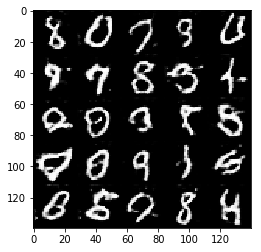

Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 1.6353
Epoch 2/2... Discriminator Loss: 0.4697... Generator Loss: 2.3065
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 2.6399
Epoch 2/2... Discriminator Loss: 0.4228... Generator Loss: 2.9028
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 0.6752... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 0.4713... Generator Loss: 2.7026
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.9719


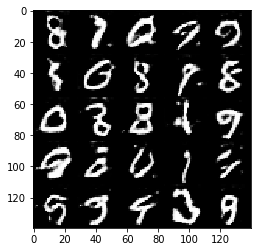

Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 3.1569
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 1.5551
Epoch 2/2... Discriminator Loss: 0.3577... Generator Loss: 3.9623
Epoch 2/2... Discriminator Loss: 0.4475... Generator Loss: 2.8865
Epoch 2/2... Discriminator Loss: 0.3512... Generator Loss: 4.5716
Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 2.1981
Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 2.2925
Epoch 2/2... Discriminator Loss: 0.4422... Generator Loss: 3.0154
Epoch 2/2... Discriminator Loss: 0.4420... Generator Loss: 2.9437
Epoch 2/2... Discriminator Loss: 0.5108... Generator Loss: 2.4214


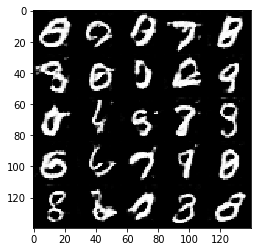

Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 1.5610
Epoch 2/2... Discriminator Loss: 0.4951... Generator Loss: 2.1579
Epoch 2/2... Discriminator Loss: 0.4630... Generator Loss: 2.3481
Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 2.2642
Epoch 2/2... Discriminator Loss: 0.3571... Generator Loss: 3.8350
Epoch 2/2... Discriminator Loss: 0.4536... Generator Loss: 3.1475
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 1.7273
Epoch 2/2... Discriminator Loss: 0.4395... Generator Loss: 2.9227
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.1414


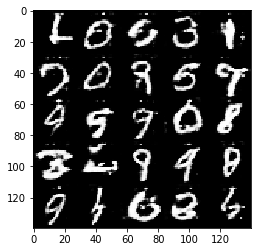

Epoch 2/2... Discriminator Loss: 0.4756... Generator Loss: 2.6138
Epoch 2/2... Discriminator Loss: 0.4310... Generator Loss: 2.9359
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 2.6372
Epoch 2/2... Discriminator Loss: 0.4410... Generator Loss: 2.8131
Epoch 2/2... Discriminator Loss: 0.4000... Generator Loss: 3.1329
Epoch 2/2... Discriminator Loss: 0.3976... Generator Loss: 3.5950
Epoch 2/2... Discriminator Loss: 0.3540... Generator Loss: 4.9217
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.7298
Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 2.1787
Epoch 2/2... Discriminator Loss: 0.4306... Generator Loss: 2.8453


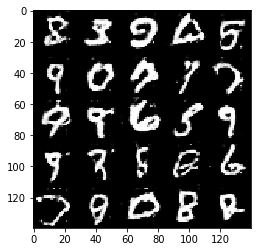

Epoch 2/2... Discriminator Loss: 0.5163... Generator Loss: 2.2982
Epoch 2/2... Discriminator Loss: 0.4194... Generator Loss: 2.8832
Epoch 2/2... Discriminator Loss: 0.9425... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 2.9195
Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 3.0400
Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 3.5898
Epoch 2/2... Discriminator Loss: 1.7771... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 0.3789... Generator Loss: 4.1173
Epoch 2/2... Discriminator Loss: 0.5163... Generator Loss: 2.4528
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 1.3363


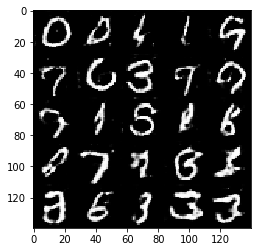

Epoch 2/2... Discriminator Loss: 0.4311... Generator Loss: 2.8255
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 2.7791
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 1.3130
Epoch 2/2... Discriminator Loss: 0.5052... Generator Loss: 2.2067
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.5913
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.3806
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.9969
Epoch 2/2... Discriminator Loss: 0.5044... Generator Loss: 2.1962
Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 1.9659
Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 3.8384


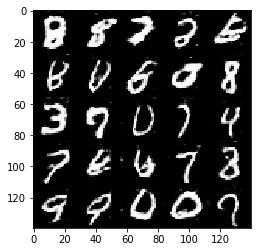

Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 1.9115
Epoch 2/2... Discriminator Loss: 0.6584... Generator Loss: 1.6900
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 1.1812
Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 1.9749
Epoch 2/2... Discriminator Loss: 0.4616... Generator Loss: 2.6756
Epoch 2/2... Discriminator Loss: 0.4002... Generator Loss: 3.0511
Epoch 2/2... Discriminator Loss: 0.3839... Generator Loss: 3.8231
Epoch 2/2... Discriminator Loss: 0.4437... Generator Loss: 2.6690
Epoch 2/2... Discriminator Loss: 0.5652... Generator Loss: 1.8742
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 1.8059


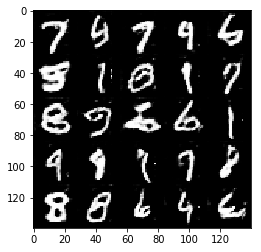

Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 3.2509
Epoch 2/2... Discriminator Loss: 0.4346... Generator Loss: 2.8067
Epoch 2/2... Discriminator Loss: 0.4283... Generator Loss: 2.8611
Epoch 2/2... Discriminator Loss: 0.4645... Generator Loss: 2.4887
Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 3.7392
Epoch 2/2... Discriminator Loss: 0.3912... Generator Loss: 3.2050
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 2.0930
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 2.3408
Epoch 2/2... Discriminator Loss: 0.5240... Generator Loss: 2.1395
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 2.3340


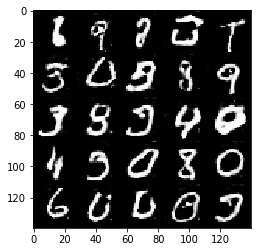

Epoch 2/2... Discriminator Loss: 0.5281... Generator Loss: 2.4702
Epoch 2/2... Discriminator Loss: 0.4340... Generator Loss: 3.0773
Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 2.2258
Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 3.6402
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 3.4892
Epoch 2/2... Discriminator Loss: 0.4823... Generator Loss: 2.2620
Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 2.3334
Epoch 2/2... Discriminator Loss: 0.4103... Generator Loss: 3.7855
Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 2.4378
Epoch 2/2... Discriminator Loss: 1.6345... Generator Loss: 0.8775


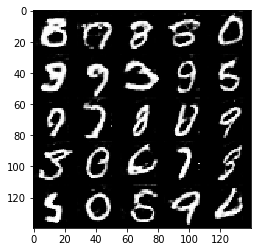

Epoch 2/2... Discriminator Loss: 0.4422... Generator Loss: 2.7973
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 2.9634
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 4.4387
Epoch 2/2... Discriminator Loss: 0.5344... Generator Loss: 2.0470
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 0.4796... Generator Loss: 2.4649
Epoch 2/2... Discriminator Loss: 0.4421... Generator Loss: 2.8644
Epoch 2/2... Discriminator Loss: 0.4163... Generator Loss: 3.0102
Epoch 2/2... Discriminator Loss: 0.4583... Generator Loss: 3.2468
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.6845


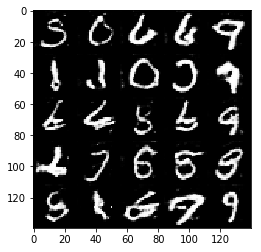

Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 2.3675
Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 4.3707
Epoch 2/2... Discriminator Loss: 1.5149... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 3.3823
Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 1.5064
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 2.4729
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 4.1903
Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 2.3126
Epoch 2/2... Discriminator Loss: 0.4670... Generator Loss: 5.0770
Epoch 2/2... Discriminator Loss: 0.4298... Generator Loss: 3.3547


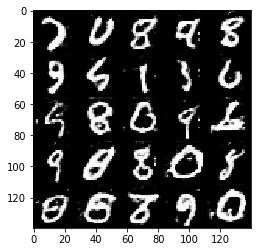

Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 3.3419
Epoch 2/2... Discriminator Loss: 0.4418... Generator Loss: 2.9090
Epoch 2/2... Discriminator Loss: 0.4428... Generator Loss: 2.7341
Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.5773
Epoch 2/2... Discriminator Loss: 0.4500... Generator Loss: 2.4740
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 2.4073
Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 3.8460
Epoch 2/2... Discriminator Loss: 0.3632... Generator Loss: 3.8895
Epoch 2/2... Discriminator Loss: 0.3943... Generator Loss: 3.1071
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 1.6978


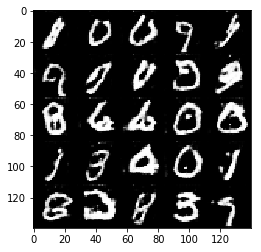

Epoch 2/2... Discriminator Loss: 0.5780... Generator Loss: 1.9744
Epoch 2/2... Discriminator Loss: 2.0072... Generator Loss: 0.3596
Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 3.0776
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 1.8938
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 1.8626
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 2.5940
Epoch 2/2... Discriminator Loss: 0.5137... Generator Loss: 1.9420
Epoch 2/2... Discriminator Loss: 0.6638... Generator Loss: 1.6533
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 3.1134
Epoch 2/2... Discriminator Loss: 0.3820... Generator Loss: 3.5249


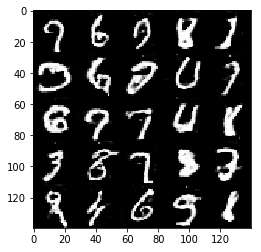

Epoch 2/2... Discriminator Loss: 0.5914... Generator Loss: 1.8224
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 3.1081
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.6785
Epoch 2/2... Discriminator Loss: 0.4495... Generator Loss: 2.9692
Epoch 2/2... Discriminator Loss: 0.3744... Generator Loss: 3.7058
Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 3.3407
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 1.3590
Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 3.9042
Epoch 2/2... Discriminator Loss: 0.4167... Generator Loss: 3.5161
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 1.6197


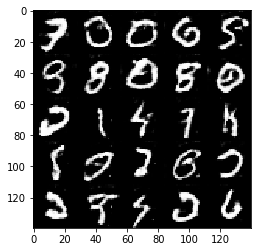

Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 1.8628
Epoch 2/2... Discriminator Loss: 0.4333... Generator Loss: 2.6494
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 0.4709... Generator Loss: 2.7258
Epoch 2/2... Discriminator Loss: 0.7006... Generator Loss: 1.8396
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 2.0971
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.1966
Epoch 2/2... Discriminator Loss: 0.4266... Generator Loss: 2.5531
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 3.6243
Epoch 2/2... Discriminator Loss: 0.5799... Generator Loss: 1.8801


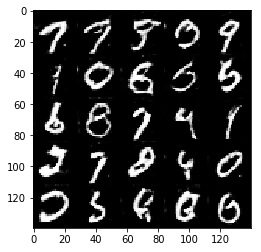

Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 2.3806
Epoch 2/2... Discriminator Loss: 0.4838... Generator Loss: 2.2617
Epoch 2/2... Discriminator Loss: 0.5992... Generator Loss: 1.8957
Epoch 2/2... Discriminator Loss: 0.4124... Generator Loss: 3.1386
Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 3.0824
Epoch 2/2... Discriminator Loss: 0.4331... Generator Loss: 2.7274
Epoch 2/2... Discriminator Loss: 0.4157... Generator Loss: 2.9457
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.1232
Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 2.7705
Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 2.2035


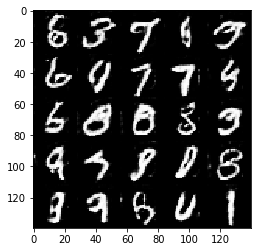

Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 1.3931
Epoch 2/2... Discriminator Loss: 0.4415... Generator Loss: 2.6790
Epoch 2/2... Discriminator Loss: 0.4573... Generator Loss: 2.7813
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.7203
Epoch 2/2... Discriminator Loss: 0.4983... Generator Loss: 2.0992
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 2.0342
Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 2.0127
Epoch 2/2... Discriminator Loss: 0.3890... Generator Loss: 3.3631
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.7468


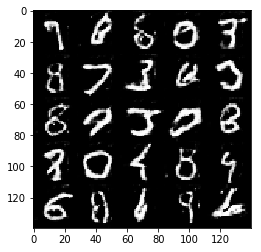

Epoch 2/2... Discriminator Loss: 0.3952... Generator Loss: 3.0302
Epoch 2/2... Discriminator Loss: 0.3892... Generator Loss: 3.2735
Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 1.2121
Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 3.5178
Epoch 2/2... Discriminator Loss: 1.8424... Generator Loss: 0.4931
Epoch 2/2... Discriminator Loss: 0.4802... Generator Loss: 2.4317
Epoch 2/2... Discriminator Loss: 0.5401... Generator Loss: 2.2817
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.3020
Epoch 2/2... Discriminator Loss: 0.4143... Generator Loss: 2.9820
Epoch 2/2... Discriminator Loss: 1.7621... Generator Loss: 0.7598


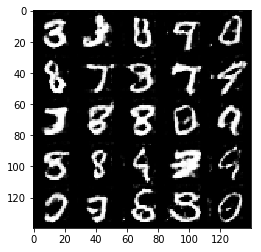

Epoch 2/2... Discriminator Loss: 0.4539... Generator Loss: 2.6637
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.5845
Epoch 2/2... Discriminator Loss: 0.4761... Generator Loss: 2.1979
Epoch 2/2... Discriminator Loss: 0.4930... Generator Loss: 2.3772
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 2.9607
Epoch 2/2... Discriminator Loss: 0.4553... Generator Loss: 2.5679
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 2.5939
Epoch 2/2... Discriminator Loss: 0.4757... Generator Loss: 2.4095
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 2.4957
Epoch 2/2... Discriminator Loss: 0.4343... Generator Loss: 2.8621


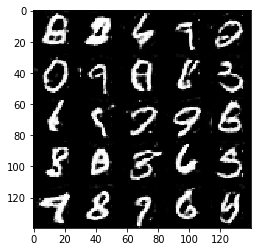

Epoch 2/2... Discriminator Loss: 0.4337... Generator Loss: 2.7339
Epoch 2/2... Discriminator Loss: 0.6698... Generator Loss: 1.4819
Epoch 2/2... Discriminator Loss: 0.4652... Generator Loss: 2.3847
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 2.3768
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 1.2034
Epoch 2/2... Discriminator Loss: 0.4183... Generator Loss: 2.8157
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 0.4298... Generator Loss: 3.0114
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.7340


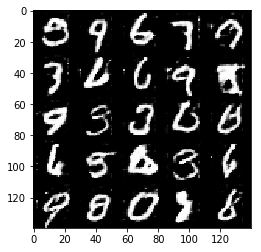

Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.1410
Epoch 2/2... Discriminator Loss: 0.4799... Generator Loss: 2.7687
Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 2.5685
Epoch 2/2... Discriminator Loss: 1.8214... Generator Loss: 0.3813
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 4.1661
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 3.0656
Epoch 2/2... Discriminator Loss: 1.5923... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.6290
Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 2.1764
Epoch 2/2... Discriminator Loss: 0.4659... Generator Loss: 2.8151


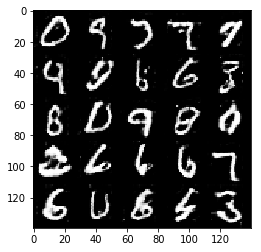

Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 2.2937
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.9844
Epoch 2/2... Discriminator Loss: 0.4018... Generator Loss: 3.4611
Epoch 2/2... Discriminator Loss: 0.4221... Generator Loss: 2.6478
Epoch 2/2... Discriminator Loss: 0.3907... Generator Loss: 3.6553
Epoch 2/2... Discriminator Loss: 1.5834... Generator Loss: 5.1120
Epoch 2/2... Discriminator Loss: 0.4500... Generator Loss: 2.8442
Epoch 2/2... Discriminator Loss: 0.4059... Generator Loss: 3.1791
Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 2.1416
Epoch 2/2... Discriminator Loss: 0.4892... Generator Loss: 2.3949


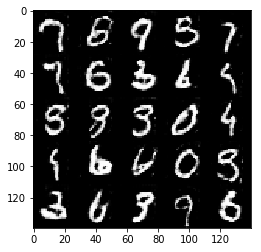

Epoch 2/2... Discriminator Loss: 0.4636... Generator Loss: 2.4610
Epoch 2/2... Discriminator Loss: 0.4461... Generator Loss: 2.8867
Epoch 2/2... Discriminator Loss: 0.5496... Generator Loss: 1.9792
Epoch 2/2... Discriminator Loss: 0.4062... Generator Loss: 3.1047
Epoch 2/2... Discriminator Loss: 0.4898... Generator Loss: 2.2782
Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 3.4754
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.3195
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 1.7260
Epoch 2/2... Discriminator Loss: 0.4146... Generator Loss: 2.9358
Epoch 2/2... Discriminator Loss: 0.4764... Generator Loss: 2.8306


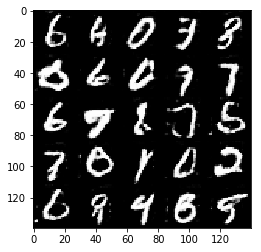

In [16]:
batch_size = 10
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 3.9855
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 1.6772... Generator Loss: 5.0446
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 4.4525
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 3.8979
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 2.0574


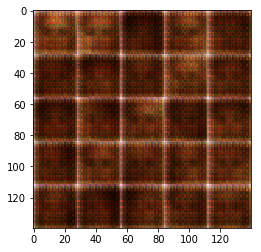

Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.8579
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 2.6746
Epoch 1/1... Discriminator Loss: 2.0815... Generator Loss: 6.7683
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 2.0451
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 2.4576
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.3490


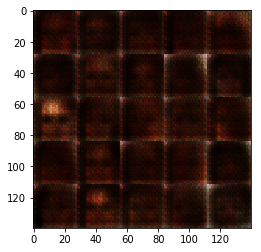

Epoch 1/1... Discriminator Loss: 2.3677... Generator Loss: 4.9498
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 2.1207
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 2.2187
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 2.8262... Generator Loss: 5.5981
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.6140
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.6294


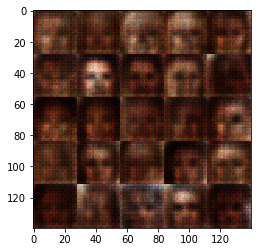

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 3.0033
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 2.2174
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 1.8579
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 1.9507... Generator Loss: 3.6280
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.7860


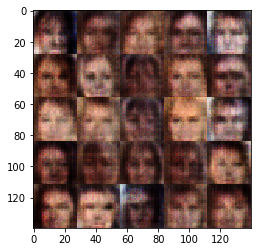

Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 1.9393... Generator Loss: 0.2872
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.6005
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.9526


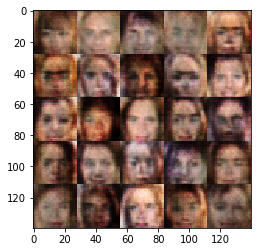

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.6018
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.9636


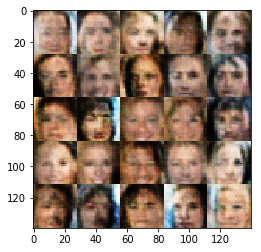

Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 2.0740
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 2.2686
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7476


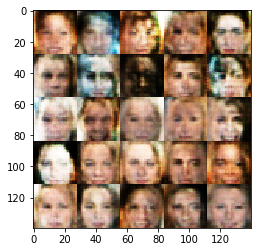

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.8759
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.5085


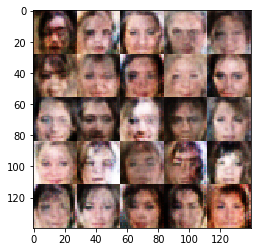

Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 1.7781
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 2.9733
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.9395


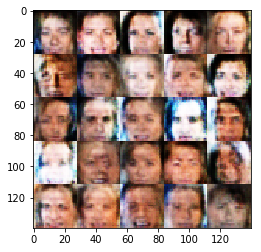

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.9501
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.7652


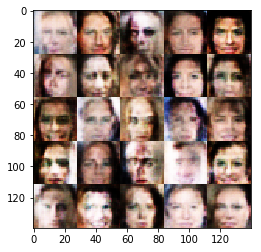

Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.1002
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.4451


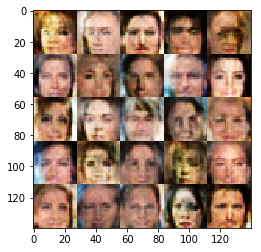

Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.8728
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.5274


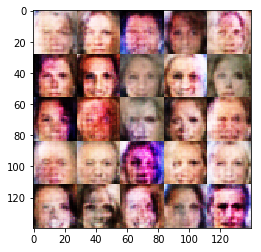

Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.8666
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.9730... Generator Loss: 3.0357
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.0563


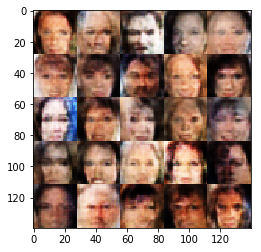

Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.7031
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.4268
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.4210


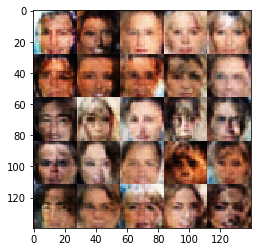

Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.3113
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.8485
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.7769
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.3498


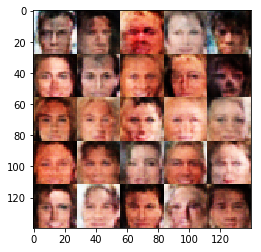

Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 2.9321
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.7354
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 2.5425
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.7743
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 2.1408
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.1274


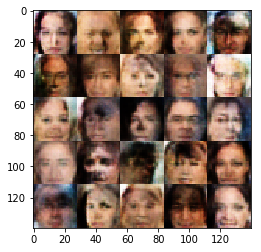

Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.7430
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.0124


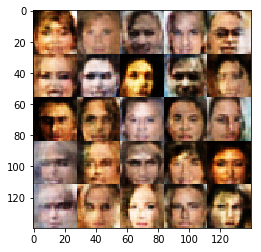

Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.8893
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.7132
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 2.0579
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 2.1953
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.6039


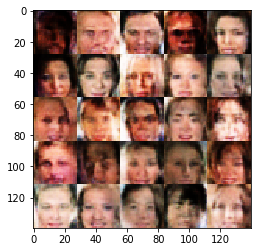

Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 2.3939
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.5876
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.3008


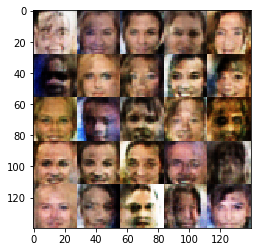

Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 2.3048... Generator Loss: 3.2663
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.5797
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.5300
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 2.1613


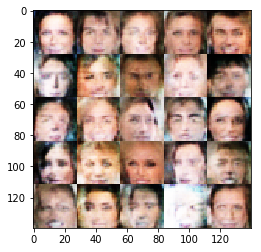

Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.5120
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.5654


In [18]:
batch_size = 100
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.